In [1]:
import re
from scipy.integrate import solve_ivp
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize

In [2]:
rxnlist = {'r1': 'A = B', 'r2' : 'B -> C'}

In [3]:
rxnparam_dict = {'r1': {'kf':1000, 'Keq': 0.3, 'Eaf': 30000.0, 'Ear': 0.0, 'Tref_C': 25.0}, 
                 'r2' : {'kf':1.0, 'Keq': -1.0, 'Eaf': 30000.0, 'Ear': 0.0, 'Tref_C': 25.0}}
rxnparam = pd.DataFrame.from_dict(rxnparam_dict, orient = 'index')
rxnparam

,kf,Keq,Eaf,Ear,Tref_C
r1,1000.0,0.3,30000.0,0.0,25.0
r2,1.0,-1.0,30000.0,0.0,25.0


In [4]:
def stoicoeff(x):
    if '*' in x:
        stoi = (x.split('*')[1], int(x.split('*')[0]))
    else:
        stoi = (x, 1)
    return stoi

In [5]:
stoicoeff('A'), stoicoeff('2*B')

(('A', 1), ('B', 2))

In [6]:
def get_rxnstoi(rxnlist):
    rxnstoi = dict()

    for k, rxn in rxnlist.items():
        rxn2 = re.split('->|=', rxn)
        rxntype = 'eqb' if '=' in rxn else 'fwd'
        reactants = [x.strip() for x in rxn2[0].split('+')]
        products = [x.strip() for x in rxn2[1].split('+')]
        stoi = {stoicoeff(x)[0]: -stoicoeff(x)[1] for x in reactants}
        stoi_products = {stoicoeff(x)[0]: stoicoeff(x)[1] for x in products}
        stoi.update(stoi_products)
        stoi.update({'rxntype': rxntype})
        rxnstoi[k] = stoi
    
    rxnstoi_df = pd.DataFrame.from_dict(rxnstoi, orient = 'index').fillna(0)
    
    return rxnstoi_df

In [7]:
rxnstoi_df = get_rxnstoi(rxnlist)
rxnstoi_df

,A,B,rxntype,C
r1,-1.0,1,eqb,0.0
r2,0.0,-1,fwd,1.0


In [8]:
rlist = list(rxnstoi_df.index)

In [9]:
clist = list(rxnstoi_df.drop('rxntype', axis = 1).columns)
stoimat = rxnstoi_df.drop('rxntype', axis = 1).to_numpy().T
print(clist)
print(stoimat)

['A', 'B', 'C']
[[-1.  0.]
 [ 1. -1.]
 [ 0.  1.]]


In [13]:
def rate(conc, stoimat, kf, Keq):
    
    ncmp = stoimat.shape[0]
    nrxn = stoimat.shape[1]
    rrate = np.zeros(nrxn)
    for r in range(nrxn):
        # calculate forward reaction rate
        rfstoi = stoimat[:, r].copy()
        rfstoi[rfstoi > 0] = 0
        rf = kf[r] * np.prod(conc ** (-rfstoi))
        # calculate reverse reaction rate
        if Keq[r] > 0:
            rrstoi = stoimat[:, r].copy()
            rrstoi[rrstoi < 0] = 0
            rr = kf[r] / Keq[r] * np.prod(conc ** (rrstoi))
        else:
            rr = 0.0
        # overall reaction rate
        rrate[r] = rf - rr

    dc = np.matmul(stoimat, rrate)
    
    return dc

In [14]:
def simulate(tspan, cinit, T, rxnparam, t_eval = None):
    
    R = 8.314
    
    kf = rxnparam['kf'].values
    Keq = rxnparam['Keq'].values
    Eaf = rxnparam['Eaf'].values
    Ear = rxnparam['Ear'].values
    Tref_C = rxnparam['Tref_C'].values
    
    kf = kf * np.exp((-Eaf / R) * (1/(T + 273) - 1/(Tref_C + 273)))
    Keq = Keq * np.exp((-(Eaf - Ear) / R) * (1/(T + 273) - 1/(Tref_C + 273)))
    rate_lam = lambda t, c: rate(c, stoimat, kf, Keq)
    csol = solve_ivp(rate_lam, tspan, cinit, method = 'BDF', t_eval = t_eval)
    
    return csol

In [15]:
csol = simulate([0, 10], [1, 0, 0], 25, rxnparam)

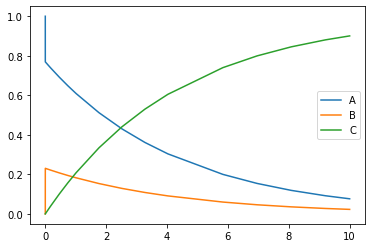

In [16]:
fig, ax = plt.subplots()
ax.plot(csol.t, csol.y[0, :], label = 'A')
ax.plot(csol.t, csol.y[1, :], label = 'B')
ax.plot(csol.t, csol.y[2, :], label = 'C')
ax.legend()

In [94]:
data_df = pd.read_csv("ABC_data.csv")
data_df.head()

,t,ca,cb,cc
0,0.000,0.957,-0.031,-0.015
1,0.263,0.557,0.330,0.044
2,0.526,0.342,0.512,0.156
3,0.789,0.224,0.499,0.310
4,1.053,0.123,0.428,0.454


In [95]:
data = dict()
data['ABC'] = {'process' : {'cinit': [1, 0, 0]}}
data['ABC']['meas'] = dict()

In [96]:
data['ABC']['meas']['ca'] = {x[0]: [x[1], x[2]] 
                             for x in zip(range(len(data_df.t.values)), data_df.t.values, data_df.ca.values)}
data['ABC']['meas']['cb'] = {x[0]: [x[1], x[2]] 
                             for x in zip(range(len(data_df.t.values)), data_df.t.values, data_df.cb.values)}
data['ABC']['meas']['cc'] = {x[0]: [x[1], x[2]] 
                             for x in zip(range(len(data_df.t.values)), data_df.t.values, data_df.cc.values)}


tmeas_list = []
for meas_var, meas_data in data['ABC']['meas'].items():
    tmeas_list += [x[0] for x in meas_data.values()]
    
data['ABC']['meas_t'] = np.unique(tmeas_list)

In [105]:
def calc_ssq(theta, data, rxnparam):
    
    rxnparam_tmp = rxnparam.copy()
    rxnparam_tmp['kf'][0] = theta[0]
    rxnparam_tmp['kf'][1] = theta[1]

    meas_varlist = ['ca', 'cb', 'cc']
    solidx = {'ca': 0, 'cb': 1, 'cc': 2}
    wt_var = [1, 1, 1]
    
    ssq = 0
    for expt in data.values():
        cinit = expt['process']['cinit']
        tspan = [0, 10]

        T = 25
        csol = simulate(tspan, cinit, T, rxnparam_tmp, expt['meas_t'])

        for i, meas_var in enumerate(meas_varlist):
            expt_t = expt['meas_t']
            data_t = [x[0] for x in expt['meas'][meas_var].values()]
            data_val = np.array([x[1] for x in expt['meas'][meas_var].values()])
            idx = np.where(np.in1d(expt_t, data_t))
            pred_val = csol.y[solidx[meas_var]][idx]

            ssq = ssq + wt_var[i] * np.sum((pred_val - data_val) ** 2)

    return ssq

In [107]:
calc_ssq(np.array([1, 1]), data, rxnparam)

0.6530175180488677

In [108]:
res = minimize(calc_ssq, np.array([1, 1]), args = (data, rxnparam), method = 'BFGS')

In [109]:
res

      fun: 0.0260833272925221
 hess_inv: array([[ 2.7173801 , -0.40426801],
       [-0.40426801,  0.3349931 ]])
      jac: array([ 8.07922333e-08, -3.61818820e-07])
  message: 'Optimization terminated successfully.'
     nfev: 36
      nit: 7
     njev: 9
   status: 0
  success: True
        x: array([2.01846548, 0.99337053])

In [82]:
rxnparam.dtypes

kf        int64
Keq       int64
Eaf       int64
Ear       int64
Tref_C    int64
dtype: object

In [43]:
type(csol.y)

numpy.ndarray

In [33]:
rxnparam

,kf,Keq,Eaf,Ear,Tref_C
r1,1,-1,30000,0,25
r2,1,-1,30000,0,25


In [119]:
def ovly_expt_pred(theta, exptid, varname, data, rxnparam):
    
    rxnparam_tmp = rxnparam.copy()
    rxnparam_tmp['kf'][0] = theta[0]
    rxnparam_tmp['kf'][1] = theta[1]

    meas_varlist = ['ca', 'cb', 'cc']
    solidx = {'ca': 0, 'cb': 1, 'cc': 2}
    
    expt = data[exptid]
    
    cinit = expt['process']['cinit']
    tspan = [0, 10]

    T = 25
    csol = simulate(tspan, cinit, T, rxnparam_tmp, expt['meas_t'])
    
    fig, ax = plt.subplots()
    ax.plot(csol.t, csol.y[solidx[varname]], label = varname)

    data_t = [x[0] for x in expt['meas'][varname].values()]
    data_val = np.array([x[1] for x in expt['meas'][varname].values()])
    
    ax.plot(data_t, data_val, 'bo')
    ax.legend()
            


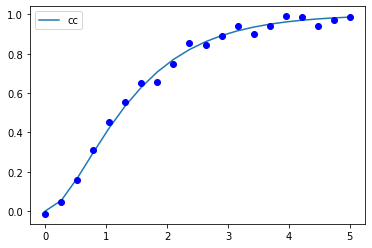

In [122]:
ovly_expt_pred(np.array([2.0, 1.0]), 'ABC', 'cc', data, rxnparam)